# Demo:  Predicting Glucose Levels using Multiple Linear Regression

In this demo, you will learn how to:
* Fit multiple linear regression models using Python's `sklearn` package.  
* Partition data into training and test subsets.
* Manipulate and visualize multivariable arrays.

We first load the packages, as usual.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Diabetes Data Example
To illustrate the concepts, we load the well-known Diabetes dataset.  This dataset is included in the `sklearn.datasets` module and can be loaded as follows.

In [2]:
from sklearn import datasets, linear_model

# Load the diabetes dataset
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

The target values `y` represent the progression of the disease after one year, which we wish to predict.  The number of attributes and samples are computed from the shape:

In [3]:
nsamp, natt = X.shape
print("num samples={0:d}  num attributes={1:d}".format(nsamp,natt))

num samples=442  num attributes=10


## Using Simple Linear Regression for Each Feature Individually

As a first attempt to predict the disease progression, we could try to predict from *one attribute at a time*.  That is, for each attribute $x_j$, we could attempt to fit a [simple linear regression](../simp_lin_reg/readme.md) model of the form
$$\hat{y} = \beta_{0,j} + \beta_{1,j}x_j$$
for prediction coefficients $\beta_{0,j}$ and $\beta_{1,j}$.

Earlier, we saw that the goodness-of-fit in simple linear regression is given by the coefficient-of-determination, $R^2$.
Let $R_j^2$ be the coefficient when predicting $y$ from $x_j$, i.e.,
$$R^2_j = \frac{s_{x_j,y}^2}{s_{x_j}^2 s_y^2}.$$
The following code computes $R^2_j$ for each variable $j$, as well as the corresponding prediction coefficients $\beta_{0,j}$ and $\beta_{1,j}$

In [4]:
ym = np.mean(y)
syy = np.mean((y-ym)**2)
Rsq = np.zeros(natt)
beta0 = np.zeros(natt)
beta1 = np.zeros(natt)
for j in range(natt):
    xm = np.mean(X[:,j])
    sxy = np.mean((X[:,j]-xm)*(y-ym))
    sxx = np.mean((X[:,j]-xm)**2)
    beta1[j] = sxy/sxx
    beta0[j] = ym - beta1[j]*xm
    Rsq[j] = (sxy)**2/sxx/syy
    
    print("j={0:1d} R^2={1:f} beta0={2:f} beta1={3:f}".format(j,Rsq[j],beta0[j],beta1[j]))
    

j=0 R^2=0.035302 beta0=152.133484 beta1=304.183075
j=1 R^2=0.001854 beta0=152.133484 beta1=69.715356
j=2 R^2=0.343924 beta0=152.133484 beta1=949.435260
j=3 R^2=0.194908 beta0=152.133484 beta1=714.741644
j=4 R^2=0.044954 beta0=152.133484 beta1=343.254452
j=5 R^2=0.030295 beta0=152.133484 beta1=281.784593
j=6 R^2=0.155859 beta0=152.133484 beta1=-639.145279
j=7 R^2=0.185290 beta0=152.133484 beta1=696.883030
j=8 R^2=0.320224 beta0=152.133484 beta1=916.138723
j=9 R^2=0.146294 beta0=152.133484 beta1=619.222821


We see that the best $R^2_j = 0.34$.  This is a somewhat poor fit, as seen in the scatter plot, which shows significant variation from the regression line.
Interestingly, we also see that `beta0` remains the same no matter which attribute is used to predict the target;
this is because the columns of 'X' have sample mean = zero.

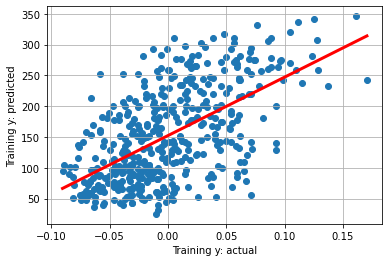

In [5]:
# Find the index of the single variable with the best R^2
imax = np.argmax(Rsq)

# Regression line over the range of x values
xmin = np.min(X[:,imax])
xmax = np.max(X[:,imax])
ymin = beta0[imax] + beta1[imax]*xmin
ymax = beta0[imax] + beta1[imax]*xmax
plt.plot([xmin,xmax], [ymin,ymax], 'r-', linewidth=3)

# Scatter plot of points
plt.scatter(X[:,imax],y)
plt.xlabel('Training y: actual')
plt.ylabel('Training y: predicted')
plt.grid()

Note that the calculations above could have been done without a for-loop using Python broadcasting:

In [6]:
# Remove the means
ym = np.mean(y) 
y1 = y-ym  # a column vecotor each minus mean
Xm = np.mean(X,axis=0) # averaging over column, resulting a row vector of dimension natt
X1 = X - Xm[None,:] # minus the same mean in each column

# Compute the correlations per features
syy = np.mean(y1**2)
Sxx = np.mean(X1**2,axis=0) #a row vector with each element indicating the variance of one attribute
Sxy = np.mean(X1*y1[:,None],axis=0) #a row vector with each element indicating the covarance on one attribute to the targer

# Compute the coefficients and R^2 value per feature
beta1 = Sxy/Sxx # element wise division, resulting a row vector containing  beta1 for each attribute
beta0 = ym - beta1*Xm # element wise multiplication, resulting a row vector containing beta0 for each attribute
Rsq = Sxy**2/Sxx/syy #a row vector containing Rsq for each attribute

Let's verify that this gives the same result:

In [7]:
for j in range(natt):
    print("j={0:1d} R^2={1:f} beta0={2:f} beta1={3:f}".format(j,Rsq[j],beta0[j],beta1[j]))

j=0 R^2=0.035302 beta0=152.133484 beta1=304.183075
j=1 R^2=0.001854 beta0=152.133484 beta1=69.715356
j=2 R^2=0.343924 beta0=152.133484 beta1=949.435260
j=3 R^2=0.194908 beta0=152.133484 beta1=714.741644
j=4 R^2=0.044954 beta0=152.133484 beta1=343.254452
j=5 R^2=0.030295 beta0=152.133484 beta1=281.784593
j=6 R^2=0.155859 beta0=152.133484 beta1=-639.145279
j=7 R^2=0.185290 beta0=152.133484 beta1=696.883030
j=8 R^2=0.320224 beta0=152.133484 beta1=916.138723
j=9 R^2=0.146294 beta0=152.133484 beta1=619.222821


## Improvements with a Multiple Variable Linear Model

One possible way to try to improve the fit is to predict using multiple attributes.  We can fit the multiple variable linear model using the `sklearn` package.  

To to this, we first create a regression object and then fit the data with this regression object.

In [8]:
regr = linear_model.LinearRegression()
regr.fit(X,y);

We can print the coefficients as follows. First `beta0`:

In [9]:
regr.intercept_       

152.1334841628965

and then the remaining `beta` coefficients:

In [10]:
regr.coef_                  

array([ -10.01219782, -239.81908937,  519.83978679,  324.39042769,
       -792.18416163,  476.74583782,  101.04457032,  177.06417623,
        751.27932109,   67.62538639])

We next compute RSS/n, a normalized version of RSS, and the $R^2$ value

In [11]:
y_pred = regr.predict(X)
nRSS = np.mean((y_pred-y)**2)
Rsq = 1-nRSS/(np.std(y)**2)
print("R^2 =            {0:f}".format(Rsq))

R^2 =            0.517749


We see $R^2$ is higher than the best single-variable model.  

We also create a scatter plot of predicted vs. actual targets:

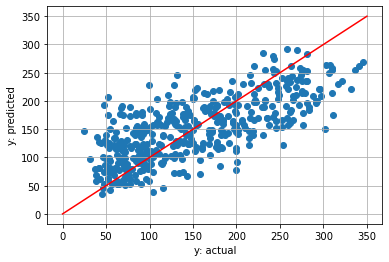

In [12]:
plt.scatter(y,y_pred)
plt.plot([0,350],[0,350],'r')
plt.xlabel('y: actual')
plt.ylabel('y: predicted')
plt.grid()

## Manually computing the coefficients

We can manually compute the regression coefficients using the least-squares matrix formulas given in class.  Using the `sklearn` package is easier, but it helps to know what is happening "under the hood" of sklearn's linear regression routine. 

To compute the coefficients manually, we first construct the matrix $\mathbf{A} = [ \mathbf{1} ~ \mathbf{X} ]$.  This is performed with the `ones` command and `hstack`.  Note that after we do this, `A` has 11 columns -- one more column that the data matrix `X`.

In [13]:
ones = np.ones((nsamp,1))
A = np.hstack((ones,X))
A.shape

(442, 11)

We next use the `lstsq` method to solve $\mathbf{y} \approx \mathbf{A}\boldsymbol{\beta}$ for $\boldsymbol{\beta}$.  This will find the desired least-squares fit. The command actually returns several quantities (the coefficients, the residuals, the rank of A, the singular values of A), but we are only interested in the coefficients, so we extract that using `out[0]`:

In [14]:
out = np.linalg.lstsq(A,y,rcond=None)
beta = out[0]

We print the coefficients as follows:

In [15]:
beta

array([ 152.13348416,  -10.01219782, -239.81908937,  519.83978679,
        324.39042769, -792.18416163,  476.74583782,  101.04457032,
        177.06417623,  751.27932109,   67.62538639])

We see that `beta[0]` matches the intercept from `regr.intercept_` above and `beta[1:]` matches the remainder of the coefficients in `regr.coef_` above.

Now let us verify that these results are the same as what we get with direct matrix inversion:

In [16]:
Am=np.matrix(A)
ym=np.matrix(y)
ym=np.transpose(ym)
Amt=np.transpose(Am)

In [17]:
beta=np.linalg.inv(Amt*Am)*Amt*ym

In [18]:
beta

matrix([[ 152.13348416],
        [ -10.01219782],
        [-239.81908937],
        [ 519.83978679],
        [ 324.39042769],
        [-792.18416163],
        [ 476.74583782],
        [ 101.04457032],
        [ 177.06417623],
        [ 751.27932109],
        [  67.62538639]])

We see that the two methods agree.

## Cross-validation using Test Data

As we will explain in the next lab, one should not evaluate the performance of a model on the data on which it is trained.  It is important to see how the model works on *new* data that is independent of the training data set.  For this reason, we will *train* the model on one subset of data samples and *test* the model on a different set of samples.  Below, we will use `ns_test=300` samples for training and the remaining `ns_test=442-300=142` for testing.

First, we partition the data into the two subsets:

In [19]:
ns_train = 300
ns_test = nsamp - ns_train
X_tr = X[:ns_train,:]     # Extracts the first ns_train rows of X
y_tr = y[:ns_train]       # Extracts the corresponding rows of y
X_test = X[ns_train:,:]
y_test = y[ns_train:]

Next we fit the model on the training data and predict the test targets using the test features.  For comparison, we will also predict the training targets using the training features.  Then we compute the RSS/n and $R^2$ for both sets of predictions.

In [22]:
regr.fit(X_tr,y_tr)

y_tr_pred = regr.predict(X_tr)
RSS_tr = np.sum((y_tr_pred-y_tr)**2)
Rsq_tr = 1-RSS_tr/ns_train/(np.std(y_tr)**2)
print("R^2_tr   =            {0:f}".format(Rsq_tr))

y_test_pred = regr.predict(X_test)
RSS_test = np.sum((y_test_pred-y_test)**2)
Rsq_test = 1-RSS_test/ns_test/(np.std(y_test)**2)
print("R^2_test =            {0:f}".format(Rsq_test))

R^2_tr   =            0.514719
R^2_test =            0.507199


As we would expect, the performance of the trained model is a bit higher on the training data than on the test data.

Keep in mind that the least-squares coefficients should never give a negative $R^2$ on the training data, but it *is* possible for them to give a negative $R^2$ on the test data.